### Enviroment preparation

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
import pyspark.sql.functions as F 
import numpy as np
import pandas as pd
import random
import time as t
import os
from subprocess import Popen
import matplotlib.pyplot as plt
%matplotlib inline

In [130]:
ControlSparkCluster('stop')

cluster stopped


In [3]:
def ControlSparkCluster(action):
    if action == 'start':
        Popen('./start_cluster.sh',shell=True)
        t.sleep(10)
        print 'cluster started'
    elif action == 'stop':
        Popen('./stop_cluster.sh',shell=True)
        sc.stop()
        t.sleep(3)
        print 'cluster stopped'
    else:
        raise Exception('Unsupported command!')
    

In [4]:
ControlSparkCluster('start')

cluster started


In [5]:
conf = SparkConf().setMaster("spark://cathome:7077").setAppName("bosh")\
.setAll((['spark.executor.cores','4']
        ,['spark.driver.cores','4']
        ,['spark.driver.memory','1g']
        ,['spark.executor.memory','1g']
        ,['spark.python.worker.memory','2g']
        ,['spark.default.parallelism','4']
       ))

In [6]:
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

### Data preparation

In [7]:
dir_name = '../../../diploma_data'

In [8]:
tr_num_file_name = 'train_numeric.csv'
tr_date_file_name = 'train_date.csv'
tr_cat_file_name = 'train_categorical.csv'

In [9]:
tr_num_data_file = '{0}/{1}'.format(dir_name,tr_num_file_name)
tr_date_data_file = '{0}/{1}'.format(dir_name,tr_date_file_name)
tr_cat_data_file = '{0}/{1}'.format(dir_name,tr_cat_file_name)

In [10]:
%%time
df_num = sqlContext.read.csv(tr_num_data_file, sep=',', header=True, inferSchema=True)
df_date = sqlContext.read.csv(tr_date_data_file, sep=',', header=True, inferSchema=True)
df_cat = sqlContext.read.csv(tr_cat_data_file, sep=',', header=True, inferSchema=True)

CPU times: user 52 ms, sys: 32 ms, total: 84 ms
Wall time: 5min 15s


### Data analisys/Data transformation

In [11]:
df_num2 = df_num
df_date2 = df_date
df_cat2 = df_cat

In [12]:
def plt_hist(counts_by_col_d):
    
    hist_v = map(float,[v for k,v in sorted(counts_by_col_d.items())])
    elems = list(xrange(0,len(hist_v)))     
    plt.figure(figsize=(25,6))
    plt.ylabel('proc')
    plt.xlabel('col id')
    plt.grid(True)
    plt.xlim([-10,len(elems) + 10])
    width = 1/1
    #plt.xticks(elems, row_fileds)
    plt.bar(elems, hist_v, width, color="blue")

In [13]:
def plt_pipe(counts_1_all_l):
    
    labels = 'Response:0', 'Response:1'
    sizes = (counts_1_all_l['count_1'],counts_1_all_l['count_all'])
    explode = (0.2, 0)  

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal') 

In [ ]:
counts_1_all_l = df_num2.select(F.sum(F.when(df_num2['Response'] == 1, 1).otherwise(0)).alias('count_1') , F.count('*').alias('count_all') ).collect()

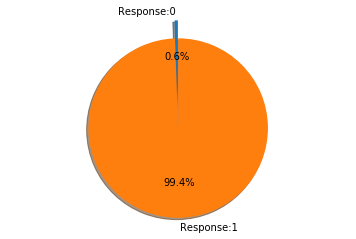

In [96]:
plt_pipe(counts_1_all_l[0].asDict())

In [14]:
counts_by_col = df_num2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df_num2.columns])

In [ ]:
counts_by_col.limit(1).toPandas()

In [15]:
counts_by_col_l = counts_by_col.collect()

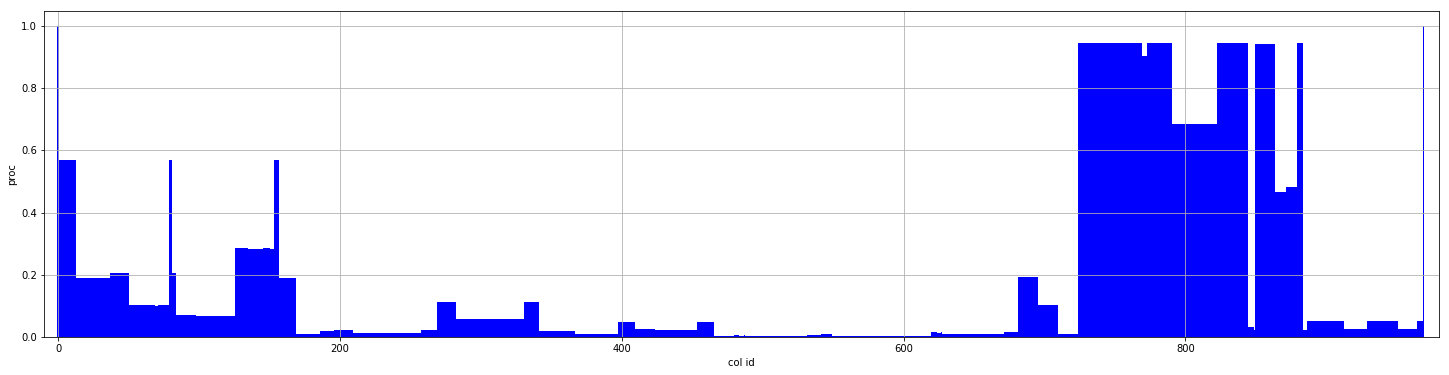

In [106]:
plt_hist(counts_by_col_l[0].asDict())

In [ ]:
col_with_resp = df_num2.filter(df_num2.Response == 1 ).select(*[(F.count(c) / F.count("*")).alias(c) for c in df_num2.columns])

In [ ]:
col_with_resp.limit(100).toPandas()

In [ ]:
col_with_resp_l = col_with_resp.collect()

In [ ]:
plt_hist(col_with_resp_l[0].asDict())

In [16]:
counts_by_col3 = df_date2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df_date2.columns])

In [ ]:
counts_by_col3.limit(1).toPandas()

In [17]:
counts_by_col_l3 = counts_by_col3.collect()

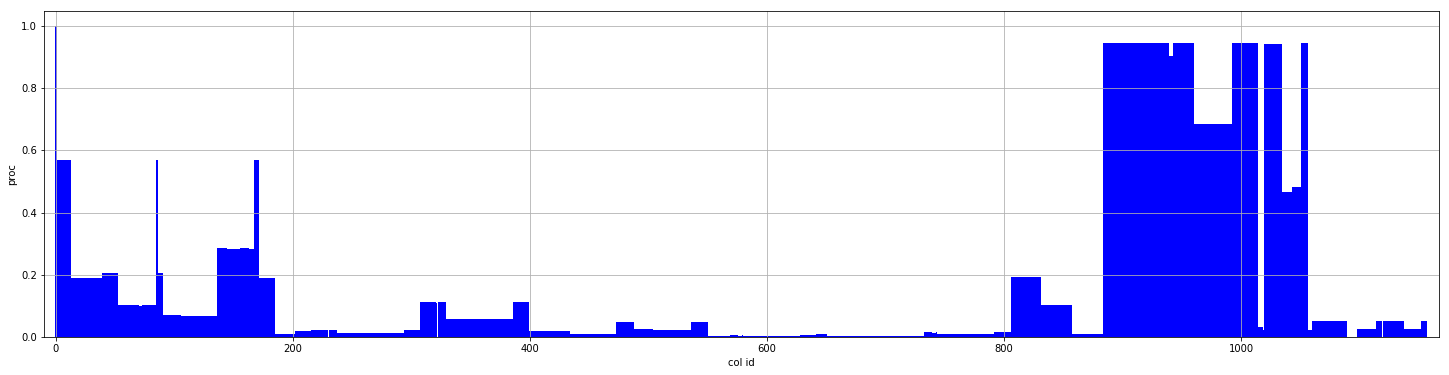

In [117]:
plt_hist(counts_by_col_l3[0].asDict())

In [18]:
counts_by_col4 = df_cat2.select(*[(F.count(c) / F.count("*")).alias(c) for c in df_cat2.columns])

In [19]:
counts_by_col_l4 = counts_by_col4.collect()

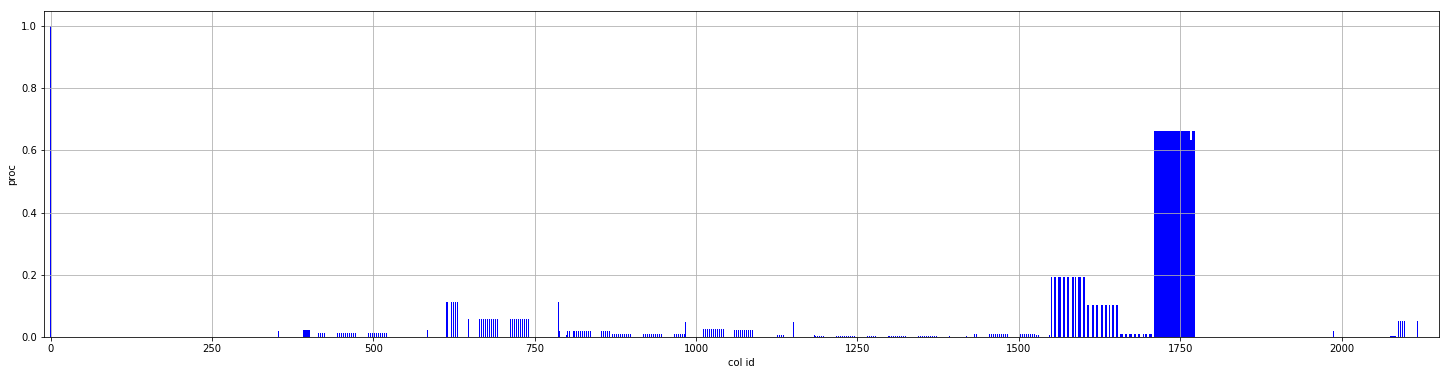

In [120]:
plt_hist(counts_by_col_l4[0].asDict())

In [20]:
filtered_num = {k: v for k, v in counts_by_col_l[0].asDict().iteritems() if v > 0.15 }

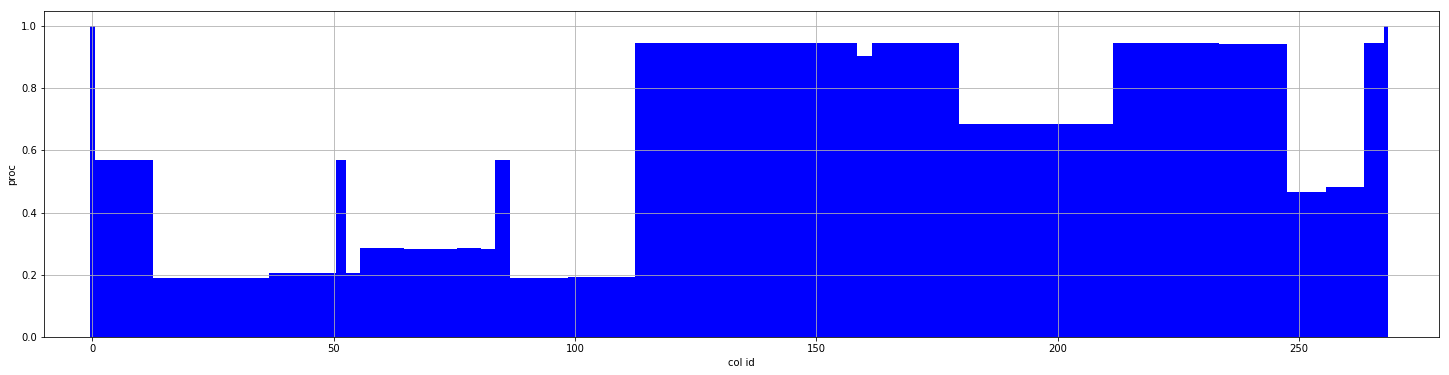

In [110]:
plt_hist(filtered_num)

In [21]:
filtered_cat = {k: v for k, v in counts_by_col_l4[0].asDict().iteritems() if v > 0.15 }
#filtered_cat

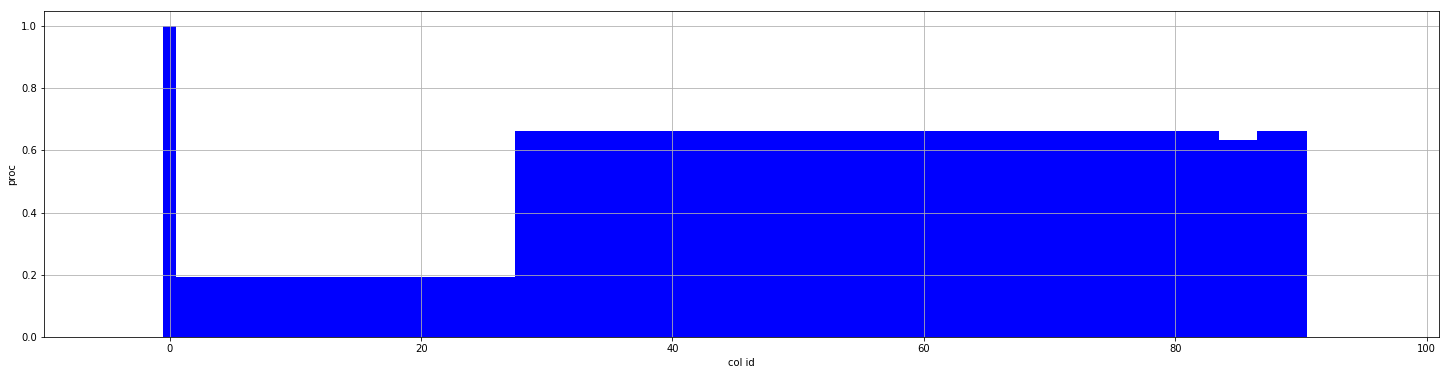

In [122]:
plt_hist(filtered_cat)

In [22]:
filtered_date = {k: v for k, v in counts_by_col_l3[0].asDict().iteritems() if v > 0.15 }

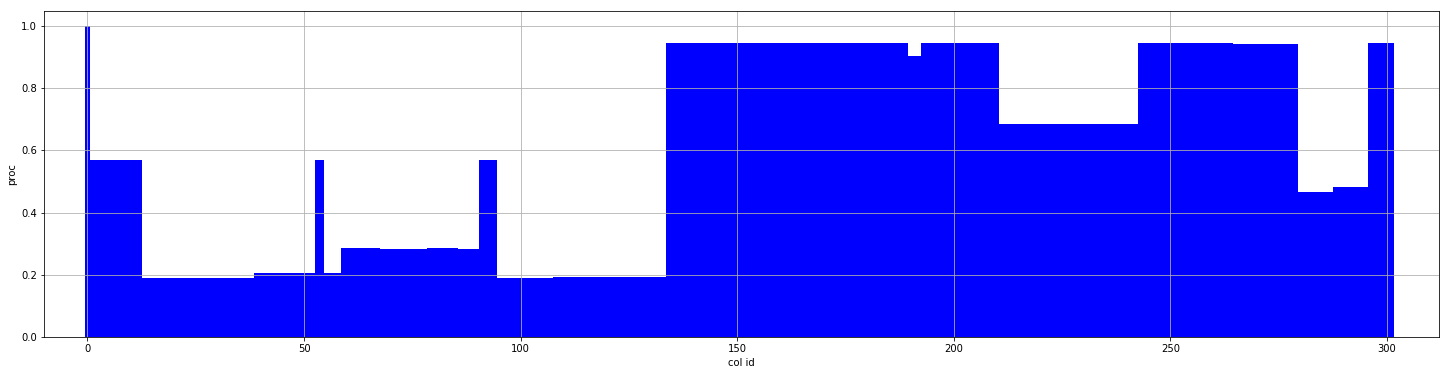

In [124]:
plt_hist(filtered_date)

In [23]:
flt_df_num = df_num2.select(*filtered_num.keys())
flt_df_date = df_date2.select(*filtered_date.keys())
flt_df_cat = df_cat2.select(*filtered_cat.keys())

In [24]:
flt_df_num = flt_df_num.drop_duplicates()
flt_df_date = flt_df_date.drop_duplicates()
flt_df_cat = flt_df_cat.drop_duplicates()

In [25]:
replace_cat_vals = F.udf(lambda val: 1 if val == 'T1' else 9999999, IntegerType())
flt_df_cat = flt_df_cat.select(flt_df_cat.Id, *[replace_cat_vals(c).alias(c) for c in flt_df_cat.columns if c != 'Id'])

In [26]:
flt_df_num = flt_df_num.na.fill(9999999)

In [27]:
flt_df_date = flt_df_date.na.fill(9999999)

In [28]:
full_df = flt_df_num.join(flt_df_date,flt_df_num.Id == flt_df_date.Id,'inner').drop(flt_df_date.Id)
full_df = full_df.join(flt_df_cat,full_df.Id == flt_df_cat.Id, 'inner').drop(flt_df_cat.Id)

In [29]:
full_df.write.csv('{0}/{1}'.format(dir_name,'full_df.csv'),sep=',',header=True,quote='')

In [31]:
full_df2 = sqlContext.read.csv('{0}/{1}'.format(dir_name,'full_df.csv'), sep=',', header=True, inferSchema=True)

### Creation of Models 

In [32]:
full_df3 = full_df2

In [87]:
from pyspark.ml.classification import GBTClassifier,RandomForestClassifier
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler,PCA

In [35]:
features = [c for c in full_df3.columns if c != 'Id' and c != 'Response']

In [36]:
vecAssembler = VectorAssembler(inputCols=features, outputCol="features")

In [37]:
%%time
ass = vecAssembler.transform(full_df3)

CPU times: user 44 ms, sys: 16 ms, total: 60 ms
Wall time: 1.04 s


In [38]:
assd = ass.select(['Id','Response','features']).drop()

In [39]:
assd.limit(5).toPandas()
#assd.printSchema()

,Id,Response,features
0,616,0,"[9999999.0, 9999999.0, 0.0, 9999999.0, 0.071, ..."
1,632,0,"[9999999.0, 9999999.0, 0.0, 9999999.0, -0.003,..."
2,681,0,"[9999999.0, 9999999.0, 9999999.0, 9999999.0, 9..."
3,1392,0,"[9999999.0, 9999999.0, 0.0, 9999999.0, -0.041,..."
4,1526,0,"[9999999.0, -0.06, 0.0, -0.048, 0.071, 0.0, 99..."


In [89]:
selector = PCA(inputCol="features",outputCol="pca_features",k=150)
selectorModel = selector.fit(assd)

In [95]:
assd_pca = selectorModel.transform(assd)

In [96]:
assd_pca = assd_pca.select(assd_pca.Id,assd_pca.Response,assd_pca.pca_features.alias('features'))

In [97]:
assd_pca.limit(10).toPandas()

,Id,Response,features
0,616,0,"[-14800141.0267, -11850196.7376, -15041527.337..."
1,632,0,"[-60212203.2331, -1938971.22418, -62560141.312..."
2,681,0,"[-185774626.071, 34756944.3064, 6541367.92099,..."
3,1392,0,"[-14638198.0166, -11615436.458, -14983852.8253..."
4,1526,0,"[-55103249.0212, 1036295.53263, 41394941.224, ..."
5,2063,0,"[-54752882.5812, 1278373.30855, 41453234.3806,..."
6,2423,0,"[-88364506.52, 94931875.8661, -25848100.0669, ..."
7,2621,0,"[21750591.8206, 79928918.9989, 575880.453382, ..."
8,3464,0,"[21574524.0218, 79897548.2899, 617134.480183, ..."
9,3554,0,"[-60363752.6437, -1971104.02712, -62507128.792..."


In [114]:
assd0 = assd_pca.filter(assd.Response == 0).sample(False, 0.006,43)


In [115]:
assd1 = assd_pca.filter(assd.Response == 1)

In [116]:
assd_n = assd0.union(assd1)

In [117]:
assd_pca.limit(10).toPandas()

,Id,Response,features
0,616,0,"[-14800141.0267, -11850196.7376, -15041527.337..."
1,632,0,"[-60212203.2331, -1938971.22418, -62560141.312..."
2,681,0,"[-185774626.071, 34756944.3064, 6541367.92099,..."
3,1392,0,"[-14638198.0166, -11615436.458, -14983852.8253..."
4,1526,0,"[-55103249.0212, 1036295.53263, 41394941.224, ..."
5,2063,0,"[-54752882.5812, 1278373.30855, 41453234.3806,..."
6,2423,0,"[-88364506.52, 94931875.8661, -25848100.0669, ..."
7,2621,0,"[21750591.8206, 79928918.9989, 575880.453382, ..."
8,3464,0,"[21574524.0218, 79897548.2899, 617134.480183, ..."
9,3554,0,"[-60363752.6437, -1971104.02712, -62507128.792..."


In [118]:
tr_dt,tst_dt = assd_pca.randomSplit([0.7,0.3])

In [119]:
rfc = RandomForestClassifier(numTrees=50, maxDepth=5, labelCol="Response", seed=201)

In [125]:
tr_dt.show()

+----+--------+--------------------+
|  Id|Response|            features|
+----+--------+--------------------+
| 221|       0|[-4.2616456197303...|
| 662|       0|[-2484159.9136024...|
| 835|       0|[-4.2615926488981...|
|1222|       0|[-1.4813420789474...|
|1225|       0|[-4.2791575362666...|
|1237|       0|[-1.8386202558379...|
|1392|       0|[-1.4638198016554...|
|1895|       0|[-6.0360067469398...|
|2063|       0|[-5.4752882581227...|
|2131|       0|[-1.8562938191507...|
|2184|       0|[-1.4804746431321...|
|2421|       0|[2.17475455652968...|
|2423|       0|[-8.8364506519994...|
|2621|       0|[2.17505918205811...|
|2891|       0|[-4.2797199445829...|
|2984|       0|[-1.8564875119256...|
|2987|       0|[-5.4890358987665...|
|3082|       0|[-4.2793724474984...|
|3181|       0|[-5.4936057598429...|
|3345|       0|[-5.4953494453717...|
+----+--------+--------------------+
only showing top 20 rows



In [120]:
%%time
model = rfc.fit(tr_dt)

CPU times: user 120 ms, sys: 8 ms, total: 128 ms
Wall time: 17min 14s


In [60]:
l = [(k,v) for k,v in enumerate(fti)]
ls = sorted(l,key= lambda r:r[1],reverse=True)
ls

[(364, 0.080267763500573408),
 (262, 0.069949887230022031),
 (115, 0.053014215830289868),
 (52, 0.043871341695302407),
 (87, 0.041532406895582907),
 (319, 0.041247726876347292),
 (136, 0.040613562023527415),
 (191, 0.032540378309814093),
 (292, 0.030011212629576345),
 (65, 0.028618167872538562),
 (88, 0.027745305876811264),
 (211, 0.027658978549798312),
 (209, 0.025916674650908883),
 (46, 0.024709042362487145),
 (202, 0.024681375148027231),
 (95, 0.023800403087806121),
 (237, 0.021274106213524168),
 (98, 0.020735794875357795),
 (86, 0.019340084386997327),
 (239, 0.018645568324960279),
 (147, 0.018303068476105213),
 (199, 0.017624475104911955),
 (220, 0.015267234878887537),
 (201, 0.015129852220690052),
 (230, 0.01437355179496767),
 (7, 0.014180281607633615),
 (155, 0.014134699071071588),
 (58, 0.013470269195850095),
 (20, 0.013443302850563903),
 (29, 0.012851967770313071),
 (159, 0.012233768998858002),
 (157, 0.011843588951752537),
 (45, 0.011717003135869854),
 (268, 0.0114124740239315

In [121]:
pr = model.transform(tst_dt)


In [122]:
pr.show()

+----+--------+--------------------+--------------------+--------------------+----------+
|  Id|Response|            features|       rawPrediction|         probability|prediction|
+----+--------+--------------------+--------------------+--------------------+----------+
| 265|       0|[-5.5059986706710...|[49.8413286444144...|[0.99682657288828...|       0.0|
| 407|       0|[-4.8227132773116...|[49.7106245438695...|[0.99421249087739...|       0.0|
| 457|       0|[7196744.98570346...|[49.7202634067274...|[0.99440526813454...|       0.0|
| 616|       0|[-1.4800141026705...|[49.8415091399721...|[0.99683018279944...|       0.0|
| 632|       0|[-6.0212203233109...|[49.7191910609986...|[0.99438382121997...|       0.0|
| 681|       0|[-1.8577462607146...|[49.7520178860112...|[0.99504035772022...|       0.0|
|1526|       0|[-5.5103249021181...|[49.8344698395687...|[0.99668939679137...|       0.0|
|1603|       0|[-2658693.2143116...|[49.8262998895224...|[0.99652599779044...|       0.0|
|2460|    

In [123]:
label_pred_list = pr.select(pr['Response'],pr['prediction']).collect()


### Testing Models

### Results evaluation

In [109]:
def matthews_corr_coef(label_pred_list): 
    import math
    tp = np.sum(1 for r in label_pred_list if r[0] == 1 and r[1] == 1)
    tn = np.sum(1 for r in label_pred_list if r[0] == 0 and r[1] == 0)
    fp = np.sum(1 for r in label_pred_list if r[0] == 0 and r[1] == 1)
    fn = np.sum(1 for r in label_pred_list if r[0] == 1 and r[1] == 0)
    print "True Positives:", tp
    print "True Negatives:", tn
    print "False Positives:", fp
    print "False Negatives:", fn
    #print "Total", df.count()
    try:
        MCC = ((tp * tn) - (fp * fn)) / math.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
    except ZeroDivisionError:
        MCC = -1
    print "Matthews correlation coefficient: ", MCC

In [124]:
matthews_corr_coef(label_pred_list)

True Positives: 0
True Negatives: 353672
False Positives: 0
False Negatives: 2041
Matthews correlation coefficient:  -1
